In [1]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import Sequential,load_model
from keras.layers import LSTM, Dense,Dropout,Bidirectional
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
tf.get_logger().setLevel('ERROR')

In [4]:
df = pd.read_csv('../dataset/distance_dataset.csv') 

X = df.drop('DataCenterID', axis=1)  # Features
y = df['DataCenterID']-3  # Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
unique_labels = np.unique(y_train.values)
print(unique_labels)
print(df.info())
num_classes = len(unique_labels)
# Example of feature engineering


[0 1 2]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TaskFileSize        2000 non-null   int64  
 1   TaskOutputFileSize  2000 non-null   int64  
 2   TaskFileLength      2000 non-null   int64  
 3   UserLatitude        2000 non-null   float64
 4   UserLongitude       2000 non-null   float64
 5   DataCenterID        2000 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 93.9 KB
None


In [ ]:
# sns.pairplot(df, hue='DataCenterID')
# plt.show()



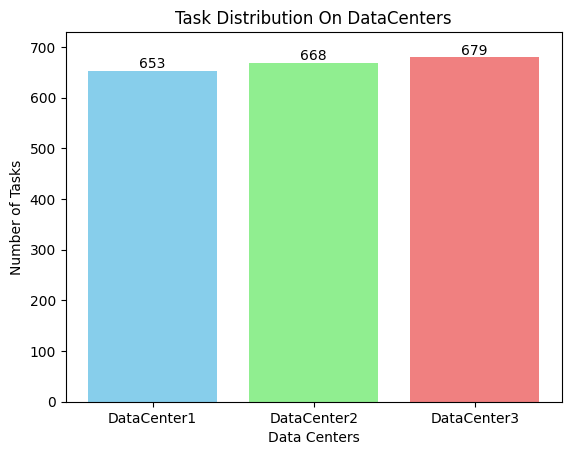

In [5]:

data_center_labels = ['DataCenter1', 'DataCenter2', 'DataCenter3']
tasks_per_data_center = df['DataCenterID'].value_counts().sort_index()

# Assigning colors
colors = ['skyblue', 'lightgreen', 'lightcoral']

# Plotting
fig, ax = plt.subplots()
bars = ax.bar(data_center_labels, tasks_per_data_center, color=colors)

# Displaying the task counts on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adjusting plot properties
plt.title('Task Distribution On DataCenters')
plt.xlabel('Data Centers')
plt.ylabel('Number of Tasks')
plt.ylim(0, max(tasks_per_data_center) + 50)  # Adjust y-axis limit for better visibility
plt.show()


In [6]:
if (len(X_train.shape)<3):
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(" xtrain ", X_train.shape, "\n", "ytrain ", y_train.shape, "\n", "xtest  ", X_test.shape, "\n", "ytest ", y_test.shape, "\n")




 xtrain  (1600, 1, 5) 
 ytrain  (1600,) 
 xtest   (400, 1, 5) 
 ytest  (400,) 



In [ ]:
def trainModel(hyperparameters):
    # Build and train the model
    model = Sequential()
    model.add(LSTM(units=int(hyperparameters['units']), input_shape=(1, X_train.shape[2]), return_sequences=True))
    model.add(Dropout(hyperparameters['dropout_rate']))
    model.add(LSTM(units=int(hyperparameters['units']) // 2))
    model.add(Dense(units=num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hyperparameters['learning_rate']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    hist = model.fit(X_train, y_train,
                        epochs=100,
                        batch_size=int(hyperparameters['batch_size']),
                        validation_data=(X_test, y_test),
                       )
    return model,hist
SNAKE_hyperparameters = {'units': 128, 'dropout_rate': 0.01, 'learning_rate': 0.001, 'batch_size': 32}
GA_hyperparameters =   {'units': 70.04564, 'dropout_rate': 0.1, 'learning_rate': 0.0021, 'batch_size': 21}   

ga_model,ga_hist= trainModel(GA_hyperparameters)
ga_accuracy = max(ga_hist.history["accuracy"])

snake_model,snake_hist= trainModel(SNAKE_hyperparameters)
snake_accuracy = max(snake_hist.history["accuracy"])

Epoch 1/100
77/77 [==============================] - 11s 31ms/step - loss: 0.7178 - accuracy: 0.7306 - val_loss: 0.5789 - val_accuracy: 0.7375
Epoch 2/100
77/77 [==============================] - 1s 12ms/step - loss: 0.4946 - accuracy: 0.7875 - val_loss: 0.5818 - val_accuracy: 0.7575
Epoch 3/100
77/77 [==============================] - 1s 10ms/step - loss: 0.4828 - accuracy: 0.7819 - val_loss: 0.4710 - val_accuracy: 0.7850
Epoch 4/100
77/77 [==============================] - 1s 9ms/step - loss: 0.4624 - accuracy: 0.7969 - val_loss: 0.4948 - val_accuracy: 0.7625
Epoch 5/100
77/77 [==============================] - 1s 13ms/step - loss: 0.4278 - accuracy: 0.8238 - val_loss: 0.4422 - val_accuracy: 0.8100
Epoch 6/100
77/77 [==============================] - 1s 16ms/step - loss: 0.4334 - accuracy: 0.8188 - val_loss: 0.4737 - val_accuracy: 0.7975
Epoch 7/100
77/77 [==============================] - 1s 11ms/step - loss: 0.4306 - accuracy: 0.8175 - val_loss: 0.4567 - val_accuracy: 0.8000
Epoch 

In [ ]:
print("snake  Accuracy: ",np.round(snake_accuracy* 100) ,'%')
print("GA Accuracy: ",np.round(ga_accuracy* 100) ,'%')

In [ ]:
plt.plot(ga_hist.history['accuracy'])
plt.plot(snake_hist.history['accuracy'])
plt.title('GA vs SNAKE Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['GA', 'SNAKE'], loc='lower right')
plt.show()

plt.plot(ga_hist.history['loss'])
plt.plot(snake_hist.history['loss'])
plt.title('GA vs SNAKE Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['GA', 'SNAKE'], loc='upper right')
plt.show()

print("\n\nGentic model summary")
print(ga_model.summary())
print("\n\nSnake model summary")
print(snake_model.summary())



In [ ]:
snake_y_pred = snake_model.predict(X_test)
snake_y_pred_classes = np.argmax(snake_y_pred, axis=1)

ga_y_pred = ga_model.predict(X_test)
ga_y_pred_classes = np.argmax(ga_y_pred, axis=1)

# Create a confusion matrix
snake_cm = confusion_matrix(y_test, snake_y_pred_classes)
ga_cm = confusion_matrix(y_test, ga_y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(snake_cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Snake Algorithm Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


plt.figure(figsize=(8, 6))
sns.heatmap(ga_cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Genitic Algorithm Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
ga_model.save('../models/ga_model_86.keras')
snake_model.save('../models/snake_model_91.keras')


# SNAKE ALGORITHM

In [ ]:

# Define the Search Space
units = [32, 64, 128]
dropout_rates = [0.1, 0.2, 0.3]
learning_rates = [0.001, 0.005]
batch_sizes = [32, 64]

# Initial Random Selection from Search Space
current_hyperparameters = {
    "units": np.random.choice(units),
    "dropout_rate": np.random.choice(dropout_rates),
    "learning_rate": np.random.choice(learning_rates),
    "batch_size": np.random.choice(batch_sizes)
}

# Store the best hyperparameters and accuracy
best_hyperparameters = None
best_accuracy = 0

# Function to train a model with given hyperparameters

# SOA Loop
for iteration in range(10):
    _,hist = trainModel(current_hyperparameters)
    accuracy=hist.history["accuracy"][-1]
    # Update best hyperparameters if better ones are found
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparameters = current_hyperparameters.copy()

        # Greedy Exploitation: Refine search around the best hyperparameters
        # Here, we're perturbing the hyperparameters slightly
        current_hyperparameters = {
            "units": max(32, best_hyperparameters["units"] + np.random.choice([-16, 16])),
            "dropout_rate": min(0.3, max(0.1, best_hyperparameters["dropout_rate"] + np.random.choice([-0.1, 0.1]))),
            "learning_rate": min(0.005, max(0.001, best_hyperparameters["learning_rate"] * np.random.choice([0.5, 1.5]))),
            "batch_size": max(32, best_hyperparameters["batch_size"] + np.random.choice([-16, 16]))
        }
    else:
        # Random Exploration
        current_hyperparameters = {
            "units": np.random.choice(units),
            "dropout_rate": np.random.choice(dropout_rates),
            "learning_rate": np.random.choice(learning_rates),
            "batch_size": np.random.choice(batch_sizes)
        }

print("Best Hyperparameters:", best_hyperparameters)


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import load_model

def predict_datacenter_id(  task_info, model_name="models/lstm87.keras"):
    expected_feature_count = 4
    if len(task_info) != expected_feature_count:
        raise ValueError(f"Expected {expected_feature_count} features, but received {len(task_info)}.")
    # Build the data dictionary and reshape the input data
    data_dict = {
        "TaskFileSize": task_info[0],
        "TaskOutputFileSize": task_info[1],
        "TaskFileLength": task_info[2],
        "UserLatitude": task_info[3],
        "UserLongitude": task_info[4],
    }

    features = np.array([[data_dict["TaskID"], data_dict["TaskFileSize"], data_dict["TaskOutputFileSize"], data_dict["TaskFileLength"]]])reshape(input_data.shape[0], 1, input_data.shape[1])
    loaded_model = load_model(model_name)
    # Make predictions using the loaded model
    predicted_dataCenter =  np.argmax(loaded_model.predict(features))
    return predicted_dataCenter
